# King County House Sales Dataset

An Automated Valuation Model (AVM) is the name given to an automated process that can estimate a home's value. This notebook constructs example AVMs using the King County House Sales Dataset. The dataset includes all single family and townhome sales (480,000+) in King County, Washington from 1999 to October 2019. The dataset is adapted from https://github.com/andykrause/kingCoData. Several related Kaggle challenges on different data include [1](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) and [2](https://www.kaggle.com/c/zillow-prize-1).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv('https://github.com/cs6220/cs6220.summer2021/blob/main/data/kingcounty_sales.csv?raw=true')
#df = pd.read_csv('/Users/reidj/Documents/GitHub/cs6220.summer2021/data/kingcounty_sales.csv')

## Data Understanding

Let's see what the data looks like.

In [3]:
df.head()

,sale_id,pinx,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,...,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket
0,1999..1,..3834000711,1/1/99,150000,1,,rebuilt - after,2019,47.728028,-122.288531,...,0,0,0,0,0,0,0,0,0,C
1,1999..4,..2600000470,1/4/99,465000,1,,reno - after,1999,47.555385,-122.159083,...,0,0,2,0,0,0,0,0,2,R
2,1999..9,..7300700080,1/4/99,157500,1,26,nochg,2019,47.746028,-122.325317,...,0,0,0,0,0,0,0,0,0,A
3,1999..14,..9530100135,1/4/99,268950,1,,nochg,2019,47.668499,-122.358732,...,0,0,0,0,0,0,0,0,0,B
4,1999..17,..2216100120,1/4/99,133000,1,,nochg,2019,47.474724,-122.151221,...,0,0,0,0,0,0,0,0,0,K


In [4]:
df.shape

(485044, 47)

In [5]:
list(df.columns)

['sale_id',
 'pinx',
 'sale_date',
 'sale_price',
 'sale_nbr',
 'sale_warning',
 'join_status',
 'join_year',
 'latitude',
 'longitude',
 'area',
 'city',
 'zoning',
 'present_use',
 'land_val',
 'imp_val',
 'year_built',
 'year_reno',
 'sqft_lot',
 'sqft',
 'sqft_1',
 'sqft_fbsmt',
 'grade',
 'fbsmt_grade',
 'condition',
 'stories',
 'beds',
 'bath_full',
 'bath_3qtr',
 'bath_half',
 'garb_sqft',
 'gara_sqft',
 'wfnt',
 'golf',
 'greenbelt',
 'noise_traffic',
 'view_rainier',
 'view_olympics',
 'view_cascades',
 'view_territorial',
 'view_skyline',
 'view_sound',
 'view_lakewash',
 'view_lakesamm',
 'view_otherwater',
 'view_other',
 'submarket']

We can see that the each sale is associated with a `sale_date`, which is in YYYY-MM-DD format. We can break this single column into the year, month, day, and even week of the year that the sale occurred.

In [6]:
df['sale_date'].head()

0    1/1/99
1    1/4/99
2    1/4/99
3    1/4/99
4    1/4/99
Name: sale_date, dtype: object

In [7]:
df['sale_date'] = pd.to_datetime(df['sale_date'])

df['sale_date_yyyymm'] = df['sale_date'].astype(str).str[:-3].str.replace('-', '')
df['sale_year'] = df['sale_date'].dt.year
df['sale_month'] = df['sale_date'].dt.month
df['sale_week'] = df['sale_date'].dt.isocalendar().week
df['sale_day'] = df['sale_date'].dt.day

We can frame the problem of predicting house sale prices as predicting a future sale price based on past, historical sale prices. It is then important to divide our training and testing data so that the test data is comprised solely of sales that take place after the sales in the training data. This is broadly known as a temporal holdout. Here, we can you the most recent year of sales data for testing and a reasonable fraction of the prior sale data for training.

In [8]:
df_train = df[(df['sale_date'] < '2019-12-01') & (df['sale_date'] >= '2016-01-01')]
df_test = df[df['sale_date'] >= '2019-12-01']

df_train.shape, df_test.shape

((103024, 52), (1557, 52))

## Data Exploration

To avoid data snooping, we'll perform further exploration only on the training data. The testing data will remain largely untouched, to reflect the real-world scenario of predicting future, unknown sales.

### Summary statistics

In [9]:
pd.concat([
    df_train.describe().T,
    df_train.mad().rename('mad'),
    df_train.skew().rename('skew'),
    df_train.kurt().rename('kurt'),
    df_train.nunique().rename('nunique')
], axis=1).T

,sale_price,sale_nbr,join_year,latitude,longitude,area,present_use,land_val,imp_val,year_built,...,sale_day,sale_date_yyyymm,sale_id,pinx,sale_date,sale_warning,join_status,city,zoning,submarket
count,1.030240e+05,103024.000000,103024.000000,103024.000000,103024.000000,103024.000000,103024.000000,1.030240e+05,1.030240e+05,103024.000000,...,103024.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7.388744e+05,2.260337,2017.907827,47.541987,-122.209267,48.218726,4.342095,2.789310e+05,3.836832e+05,1975.185549,...,15.793660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.432385e+05,1.214542,4.544317,0.145867,0.143572,26.624269,7.551418,2.836510e+05,2.545686e+05,31.165561,...,8.633305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.029300e+04,1.000000,1999.000000,47.159863,-122.527592,1.000000,2.000000,0.000000e+00,0.000000e+00,1900.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,4.347288e+05,1.000000,2019.000000,47.432029,-122.323404,26.000000,2.000000,1.340000e+05,2.280000e+05,1954.000000,...,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,6.230000e+05,2.000000,2019.000000,47.554689,-122.224210,48.000000,2.000000,2.200000e+05,3.280000e+05,1978.000000,...,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,8.600000e+05,3.000000,2019.000000,47.670076,-122.121397,71.000000,2.000000,3.380000e+05,4.780000e+05,2003.000000,...,23.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,3.000000e+07,12.000000,2019.000000,47.777763,-121.161729,100.000000,29.000000,2.489500e+07,6.680000e+06,2020.000000,...,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mad,3.205518e+05,0.979934,2.065061,0.122349,0.115829,23.052318,4.246298,1.520684e+05,1.765930e+05,26.165025,...,7.468574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
skew,8.083695e+00,0.992997,-3.920502,-0.348078,0.970873,0.047963,2.952436,1.552845e+01,2.763862e+00,-0.427643,...,-0.026548,0.089187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


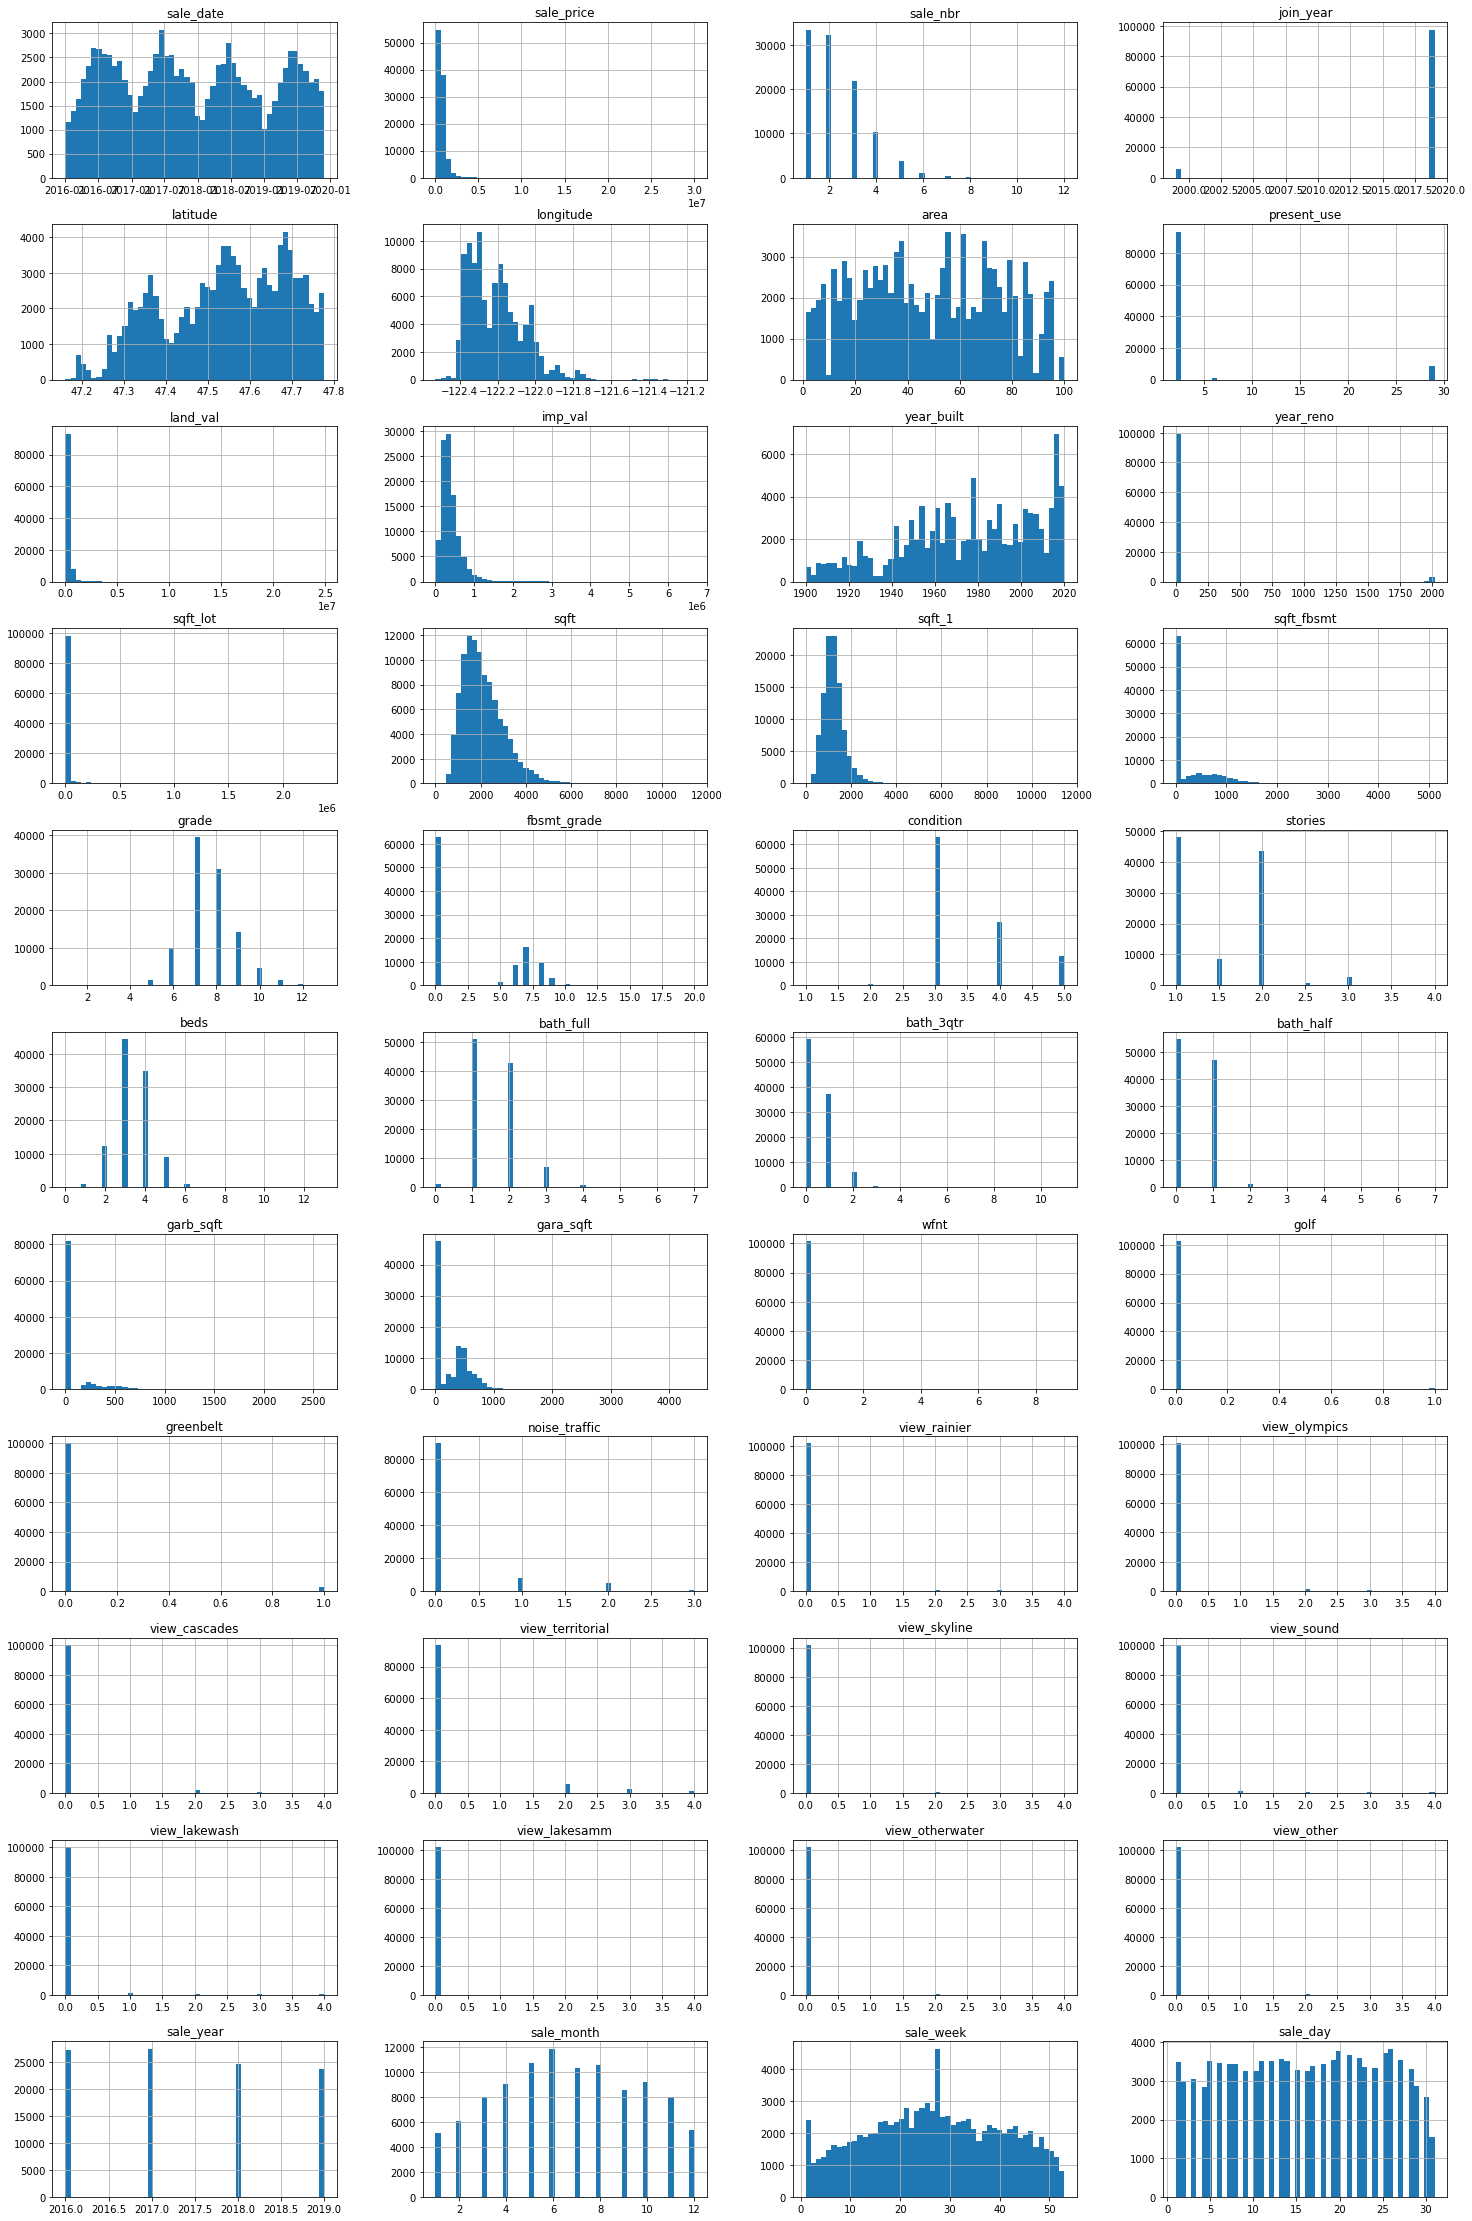

In [10]:
df_train.hist(bins=50, figsize=(25, 40), layout=(11, 4));

### Home Facts and Features

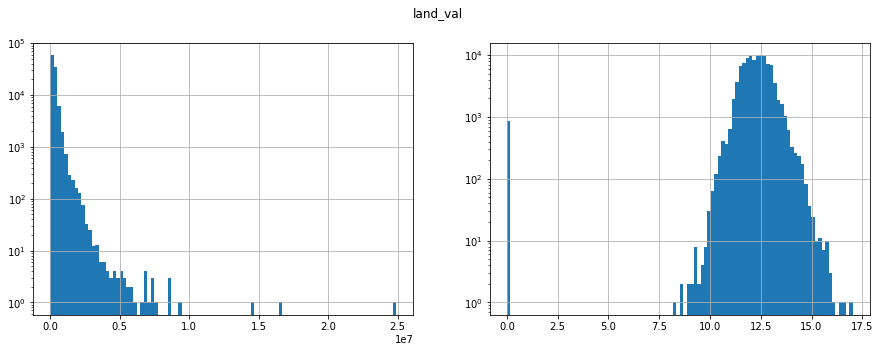

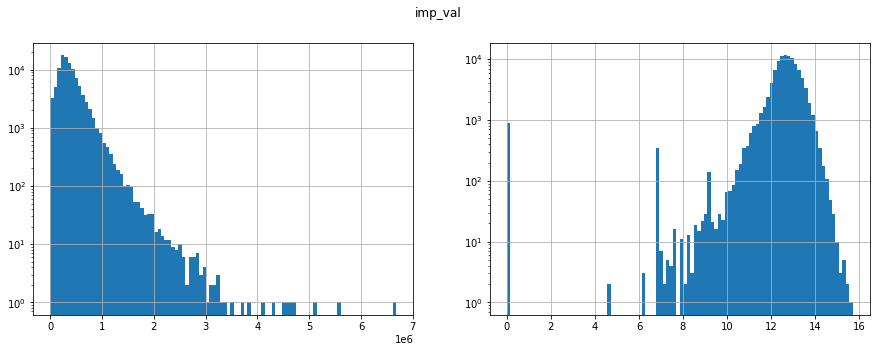

In [11]:
for col in ['land_val', 'imp_val']:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    df_train[col].hist(bins=100, log=True, figsize=(15, 5), ax=axes[0]);
    np.log1p(df_train[col]).hist(bins=100, log=True, figsize=(15, 5), ax=axes[1]);
    plt.suptitle(col)

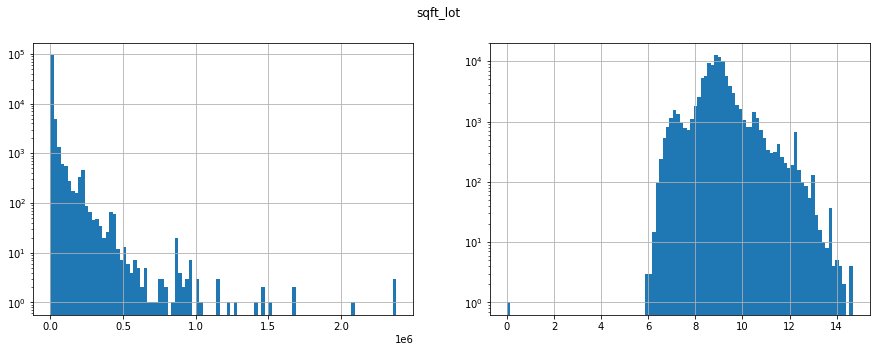

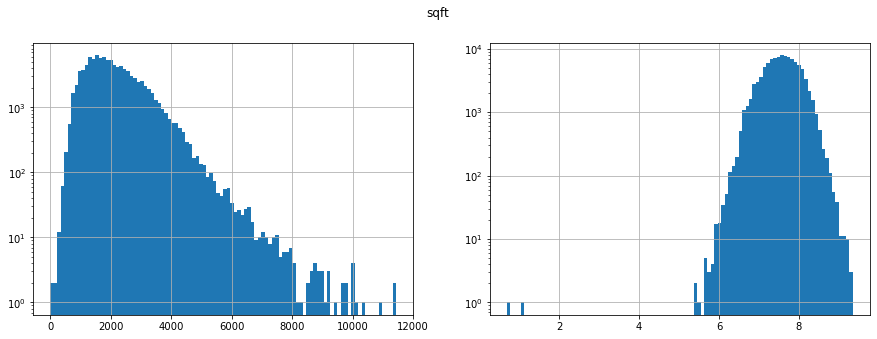

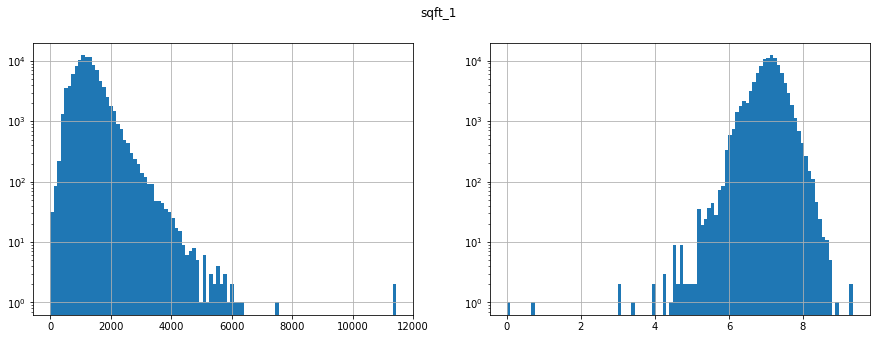

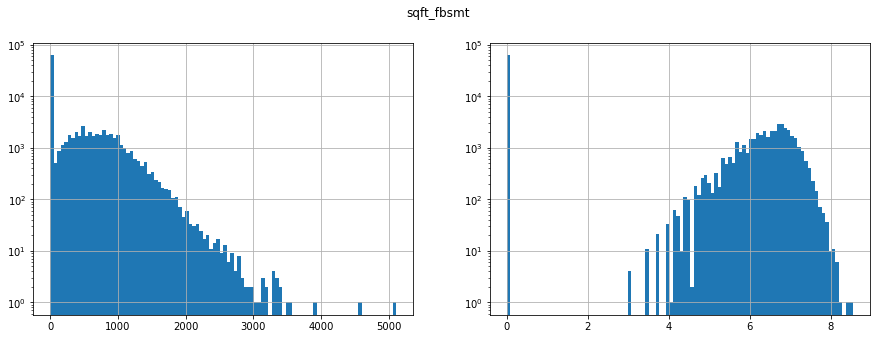

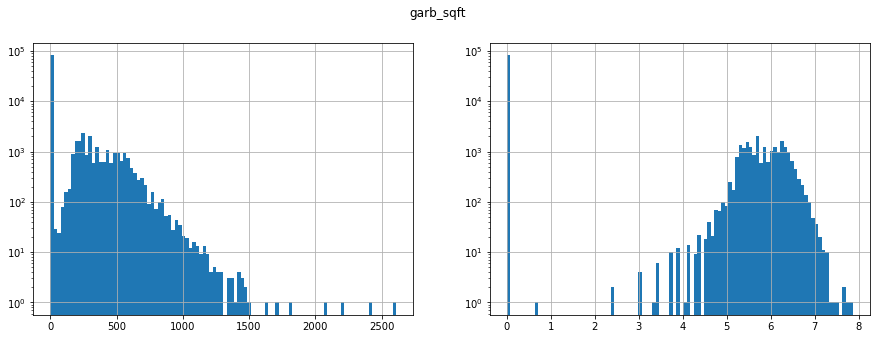

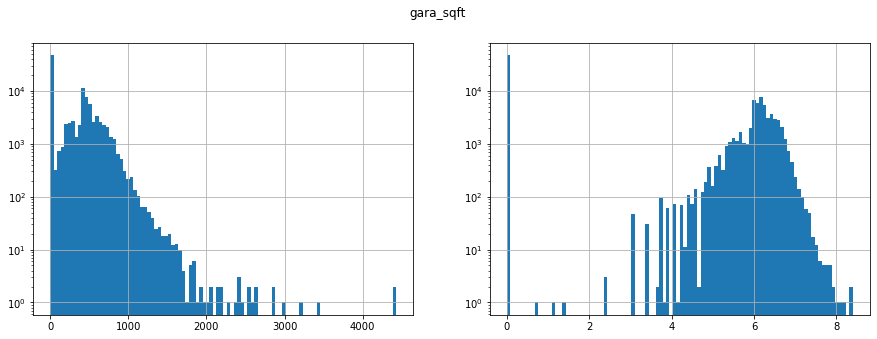

In [12]:
for col in ['sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt', 'garb_sqft', 'gara_sqft']:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    df_train[col].hist(bins=100, log=True, figsize=(15, 5), ax=axes[0]);
    np.log1p(df_train[col]).hist(bins=100, log=True, figsize=(15, 5), ax=axes[1]);
    plt.suptitle(col)

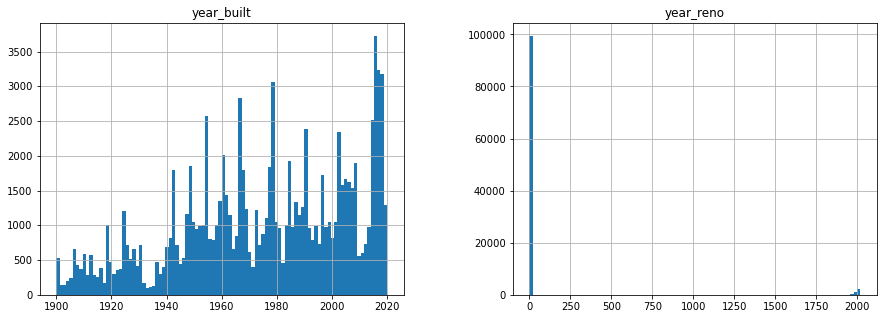

In [13]:
df_train[['year_built', 'year_reno']].hist(bins=100, figsize=(15, 5));

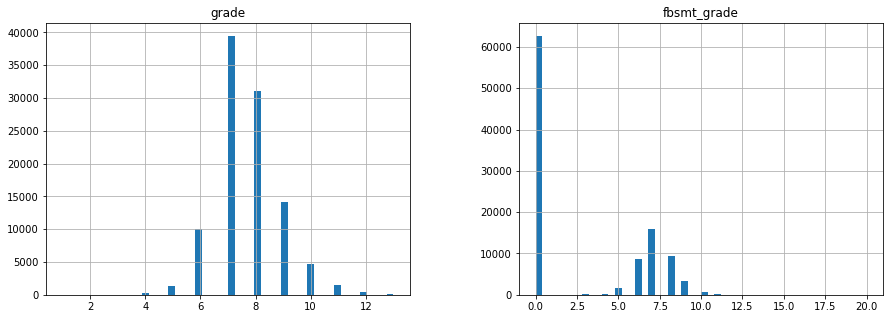

In [14]:
df_train[['grade', 'fbsmt_grade']].hist(bins=50, figsize=(15, 5));

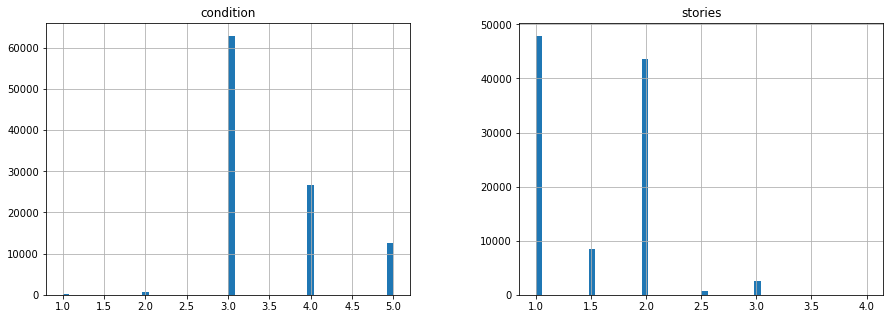

In [15]:
df_train[['condition', 'stories']].hist(bins=50, figsize=(15, 5));

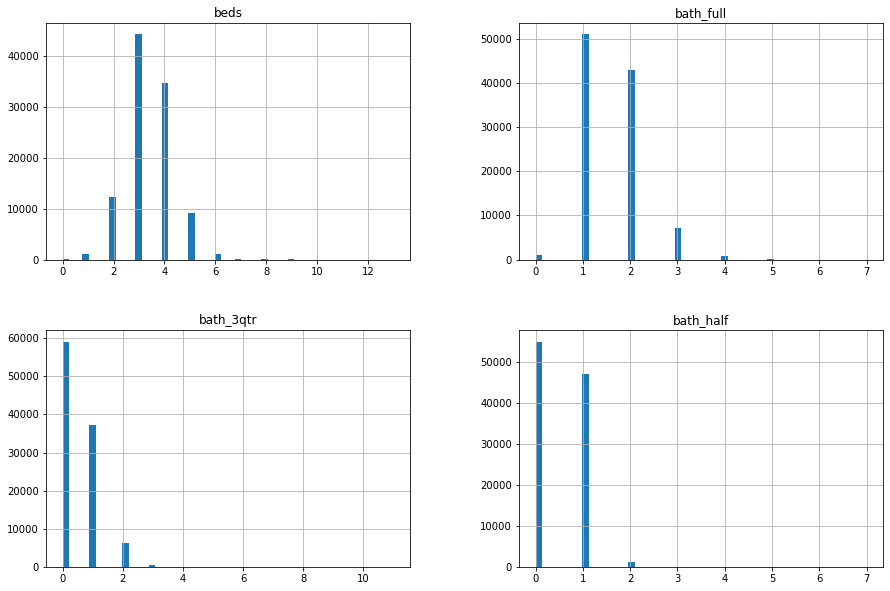

In [16]:
df_train[['beds', 'bath_full', 'bath_3qtr', 'bath_half']].hist(bins=50, figsize=(15, 10));

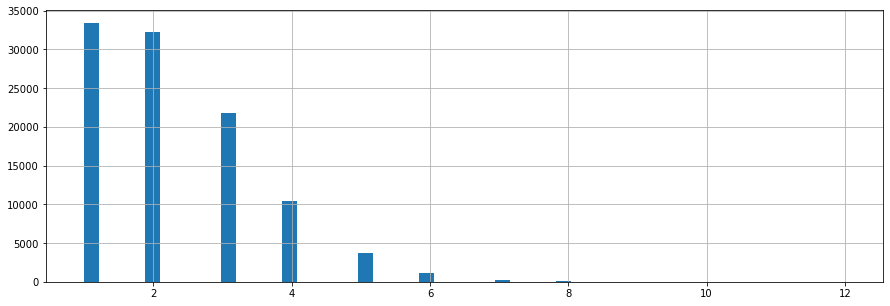

In [17]:
df_train['sale_nbr'].hist(bins=50, figsize=(15, 5));

### Sale Price

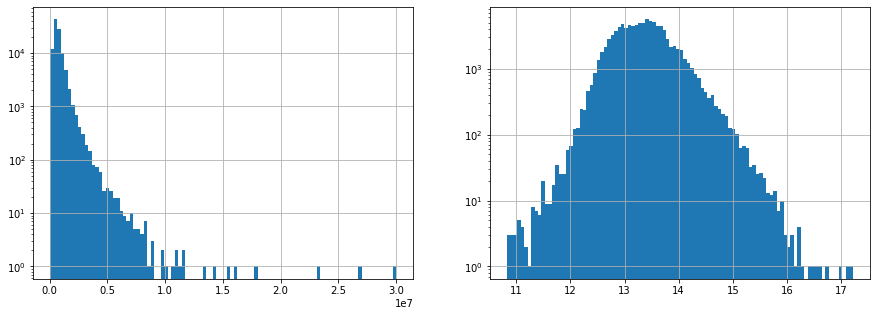

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_train['sale_price'].hist(bins=100, log=True, figsize=(15, 5), ax=axes[0]);
np.log1p(df_train['sale_price']).hist(bins=100, log=True, figsize=(15, 5), ax=axes[1]);

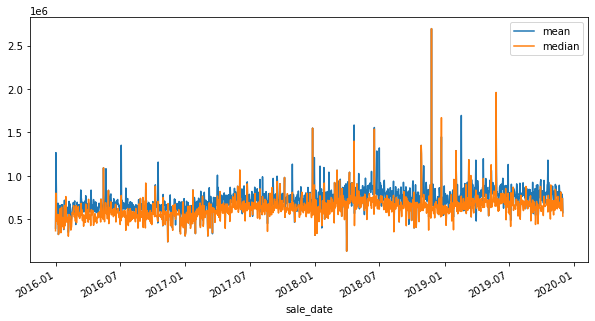

In [19]:
df_train.groupby('sale_date').agg(
    {'sale_price': [np.mean, np.median]}
).droplevel(0, axis=1).plot(figsize=(10, 5));

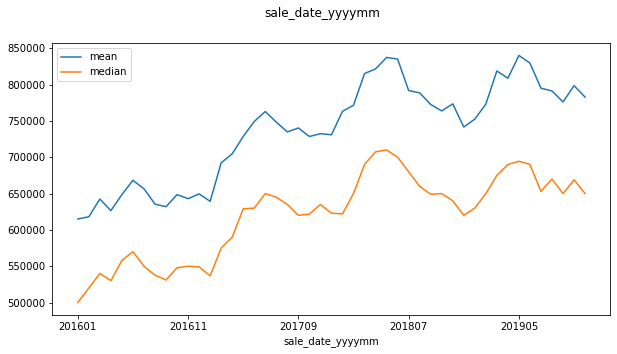

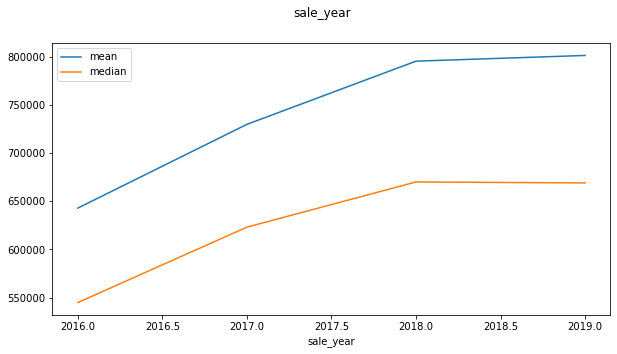

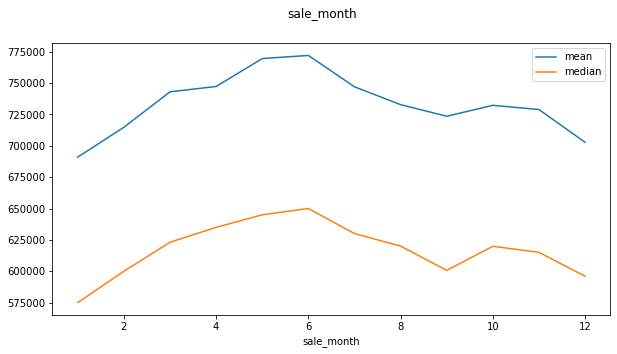

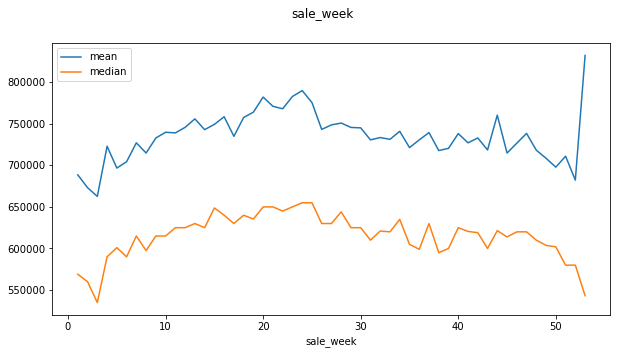

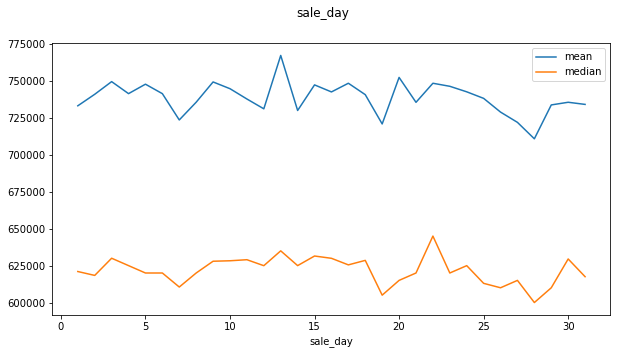

In [20]:
for col in ['sale_date_yyyymm', 'sale_year', 'sale_month', 'sale_week', 'sale_day']:
    df_train.groupby(col).agg(
        {'sale_price': [np.mean, np.median]}
    ).droplevel(0, axis=1).plot(figsize=(10, 5));
    plt.suptitle(col)

## Data Preprocessing

Based on our exploration of the data, we can perform some data preprocessing.

We can first organize the columns into groups of features.

In [21]:
def get_feature_dict():
    num_features = [
        'latitude',
        'longitude'
    ]
    num_log_features = [
        'land_val',
        'imp_val',
        'sqft_lot',
        'sqft',
        'sqft_1',
        'sqft_fbsmt',
        'garb_sqft',
        'gara_sqft'
    ]
    cat_features = [
        #'area',
        #'city',
        'sale_nbr',
        'zoning',
        'present_use',
        'year_built',
        'year_reno',
        'grade',
        'fbsmt_grade',
        'condition',
        'stories',
        'beds',
        'bath_full',
        'bath_3qtr',
        'bath_half',
        'wfnt',
        'golf',
        'greenbelt',
        'noise_traffic',
        'view_rainier',
        'view_olympics',
        'view_cascades',
        'view_territorial',
        'view_skyline',
        'view_sound',
        'view_lakewash',
        'view_lakesamm',
        'view_otherwater',
        'view_other',
        #'sale_date',
        #'sale_date_yyyymm',
        'sale_year',
        'sale_month',
    ]

    feature_dict = {
        'nums': num_features,
        'num_logs': num_log_features,
        'cats': cat_features
    }

    return feature_dict


feature_dict = get_feature_dict()

id_cols = ['sale_id', 'pinx', 'submarket']
response_col = 'sale_price'
feature_cols = feature_dict['nums'] + feature_dict['num_logs'] + feature_dict['cats']

We can calculate the mutual information between the features and the response variable.

In [22]:
train_mi = mutual_info_regression(OrdinalEncoder().fit_transform(df_train[feature_cols]), df_train[response_col])
df_train_mi = pd.DataFrame(train_mi, index=df_train[feature_cols].columns, columns=['mutual_info'])

In [23]:
df_train_mi.sort_values('mutual_info', ascending=False)

,mutual_info
imp_val,0.520387
land_val,0.508658
latitude,0.393077
zoning,0.356756
grade,0.277367
sqft,0.270765
longitude,0.155640
sqft_1,0.128590
year_built,0.121335
sqft_lot,0.091564


## Evaluation Metrics

We can define several evaluation metrics that can be used to compare candidate models.

In [24]:
def mean_percentage_error(true, pred, epsilon=1e-6):
    """Mean Percentage Error (MPE)."""
    pe = (pred - true) / (true + epsilon)
    return np.mean(pe)


def median_absolute_percentage_error(true, pred, epsilon=1e-6):
    """Median Absolute Percentage Error (MdAPE)."""
    ape = np.abs(pred - true) / (true + epsilon)
    return np.median(ape)


def median_percentage_error(true, pred, epsilon=1e-6):
    """Median Percentage Error (MdPE)."""
    pe = (pred - true) / (true + epsilon)
    return np.median(pe)


def evaluate_preds(y_test, y_pred):
    output = {}
    output['R2'] = r2_score(y_test, y_pred)
    output['MAE'] = mean_absolute_error(y_test, y_pred)
    output['MdAE'] = median_absolute_error(y_test, y_pred)
    output['MPE'] = mean_percentage_error(y_test, y_pred)
    output['MdPE'] = median_percentage_error(y_test, y_pred)
    output['MAPE'] = mean_absolute_percentage_error(y_test, y_pred)
    output['MdAPE'] = median_absolute_percentage_error(y_test, y_pred)
    return output

## Modeling

Now let's try a suite of regression models.

In [25]:
reg_models = {
    "Linear Regression": LinearRegression(),
    "KNN Regressor (n_neighbors=5)": KNeighborsRegressor(n_neighbors=5),
    "KNN Regressor (n_neighbors=25)": KNeighborsRegressor(n_neighbors=25),
    "Decision Tree Regressor (max_depth=None)": DecisionTreeRegressor(max_depth=None, random_state=0),
    "Decision Tree Regressor (max_depth=25)": DecisionTreeRegressor(max_depth=25, random_state=0),
    "Random Forest Regressor (n_estimators=5)": RandomForestRegressor(n_estimators=5, random_state=0),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(128, 32), batch_size=512, max_iter=20, tol=1e10, random_state=0)
}

### Initial featurization.

We'll start with a very simple preprocessing and featurization of the data.

In [26]:
features = feature_dict['nums'] + feature_dict['num_logs'] + feature_dict['cats']
cat_features = list(df_train[features].select_dtypes(include=['object']).columns)
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)


def get_train_data1(df_train):
    df_train = df_train.copy()

    X_train = df_train[features].copy()
    y_train = df_train[response_col]

    X_train[cat_features] = ordinal_encoder.fit_transform(X_train[cat_features])
    X_train = X_train.fillna(X_train.median())

    return X_train, y_train


def get_test_data1(df_test):
    df_test = df_test.copy()

    X_test = df_test[features].copy()
    y_test = df_test[response_col]

    X_test[cat_features] = ordinal_encoder.transform(X_test[cat_features])
    X_test = X_test.fillna(X_test.median())

    return X_test, y_test

In [27]:
X_train, y_train = get_train_data1(df_train)

for name in reg_models.keys():
    print("Fitting {}...".format(name))
    %time reg_models[name].fit(X_train, y_train)
    print("")

Fitting Linear Regression...
CPU times: user 201 ms, sys: 9.78 ms, total: 211 ms
Wall time: 66 ms

Fitting KNN Regressor (n_neighbors=5)...
CPU times: user 56.7 ms, sys: 979 µs, total: 57.7 ms
Wall time: 9.54 ms

Fitting KNN Regressor (n_neighbors=25)...
CPU times: user 46.7 ms, sys: 921 µs, total: 47.7 ms
Wall time: 7.89 ms

Fitting Decision Tree Regressor (max_depth=None)...
CPU times: user 2.48 s, sys: 14.8 ms, total: 2.5 s
Wall time: 1.62 s

Fitting Decision Tree Regressor (max_depth=25)...
CPU times: user 1.5 s, sys: 14.6 ms, total: 1.51 s
Wall time: 1.53 s

Fitting Random Forest Regressor (n_estimators=5)...
CPU times: user 5.12 s, sys: 16.3 ms, total: 5.13 s
Wall time: 5.14 s

Fitting MLP Regressor...
CPU times: user 18.9 s, sys: 150 ms, total: 19 s
Wall time: 3.31 s



In [28]:
X_test, y_test = get_test_data1(df_test)

reg_preds1 = {}
for name in reg_models.keys():
    y_pred_i = reg_models[name].predict(X_test)
    reg_preds1[name] = y_pred_i

In [29]:
results1 = pd.DataFrame([evaluate_preds(y_test, reg_preds1[name])
                         for name in reg_models.keys()],
                        index=reg_models.keys())
results1.sort_values('MdAPE', ascending=True)

,R2,MAE,MdAE,MPE,MdPE,MAPE,MdAPE
Random Forest Regressor (n_estimators=5),0.831481,131100.824791,59600.000000,0.027420,-0.012439,0.154486,0.087692
Decision Tree Regressor (max_depth=25),0.586535,167508.920863,73000.000000,0.026675,-0.005763,0.185894,0.106429
MLP Regressor,0.687156,181230.990185,81199.711762,0.083787,-0.011913,0.234048,0.110087
Decision Tree Regressor (max_depth=None),0.594756,169130.739242,75000.000000,0.032764,-0.012500,0.197114,0.113761
KNN Regressor (n_neighbors=25),0.657031,183355.695157,77717.520000,0.027851,-0.057915,0.230470,0.115747
KNN Regressor (n_neighbors=5),0.650126,193900.681567,84800.000000,0.021577,-0.074069,0.251571,0.135351
Linear Regression,0.662963,201965.185543,119709.747222,0.159189,0.119665,0.256920,0.173294


### Additional featurization.

Given our initial results, we can perform more sophisticated preprocessing and featurization of the data.

To start, we can define special encoders for the categorical and numerical feature data.

In [30]:
class CategoricalEncoder:
    """Categorical encoder."""
    def __init__(self, categorical_cols, max_categories=None):
        self.categorical_cols_ = categorical_cols
        self.max_categories_ = max_categories
        self.categorical_values_ = None
        self.dummy_cols_ = None

    def fit(self, X):
        categorical_values = {}

        if len(self.categorical_cols_) > 0:
            for col in self.categorical_cols_:
                if np.issubdtype(X[col].dtype, np.integer):
                    X[col] = X[col].astype(float)
                X[col] = X[col].astype(str)

            for col in self.categorical_cols_:
                categorical_values[col] = X[col].value_counts().index

            counts = X[col].value_counts()
            if self.max_categories_ is not None and len(counts) > self.max_categories_:
                to_replace = list(counts.index[self.max_categories_:])
                if to_replace:
                    X[col] = X[col].replace(to_replace, counts.index[0])

            X = pd.get_dummies(X, columns=self.categorical_cols_, prefix_sep='_')

        self.categorical_values_ = categorical_values
        self.dummy_cols_ = X.columns

        return self

    def transform(self, X):
        if len(self.categorical_cols_) > 0:
            for col in self.categorical_cols_:
                if np.issubdtype(X[col].dtype, np.integer):
                    X[col] = X[col].astype(float)
                X[col] = X[col].astype(str)

            for col in self.categorical_cols_:
                values = list(self.categorical_values_[col])
                for value in X[col].unique():
                    if value not in values:
                        mode = values[0]
                        X[col] = X[col].replace(value, mode)

            X = pd.get_dummies(X, columns=self.categorical_cols_, prefix_sep='_')

            dummy_cols = list(self.dummy_cols_)
            if not isinstance(dummy_cols, list):
                dummy_cols = [dummy_cols]
            if set(X.columns) != set(dummy_cols):
                missing_cols = list(set(dummy_cols) - set(X.columns))
                X_dummies = pd.DataFrame(columns=dummy_cols)
                _, X = X_dummies.align(X, join='left', axis=1)
                X[missing_cols] = X[missing_cols].fillna(0)
            X = X[dummy_cols]

        return X

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    
class NumericalEncoder:
    """Numerical encoder."""
    def __init__(self, agg_numerics, categoricals, statistics):
        self.agg_numerics_ = agg_numerics
        self.categoricals_ = categoricals
        self.statistics_ = statistics
        self.encodings_ = {}

    def _encoder(self, X, cat, stat, num):
        return X.groupby(cat)[num].agg(stat).to_dict()

    def fit(self, X, y=None):
        self.n_features_ = X.shape[1]
        for cat in self.categoricals_:
            for stat in self.statistics_:
                for num in self.agg_numerics_:
                    self.encodings_[(cat, stat, num)] = self._encoder(X, cat, stat, num)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for cat in self.categoricals_:
            for stat in self.statistics_:
                for num in self.agg_numerics_:
                    X[f'{cat}_{stat}_{num}'] = X[cat].map(
                        self.encodings_[(cat, stat, num)]).astype(np.float32)
        return X

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [31]:
features = feature_dict['nums'] + feature_dict['num_logs'] + feature_dict['cats']

categorical_encoder = CategoricalEncoder(
    feature_dict['cats'],
    max_categories=20
)
numerical_encoder = NumericalEncoder(
    agg_numerics=['sqft', 'sqft_lot', 'year_built'],
    categoricals=['submarket'],
    statistics=['mean', 'std']
)

def get_train_data2(df_train):
    df_train = df_train.copy()

    X_train = df_train[features + ['submarket']].copy()
    y_train = df_train[response_col]

    for col in feature_dict['nums'] + feature_dict['num_logs']:
        if col in feature_dict['num_logs']:
            X_train[col] = np.log1p(X_train[col])

    X_train = numerical_encoder.fit_transform(X_train)
    X_train = X_train.drop(['submarket'], axis=1)    
    X_train = categorical_encoder.fit_transform(X_train)
    X_train = X_train.fillna(X_train.median())
    return X_train, y_train


def get_test_data2(df_test):
    df_test = df_test.copy()

    X_test = df_test[features + ['submarket']].copy()
    y_test = df_test[response_col]

    for col in feature_dict['nums'] + feature_dict['num_logs']:
        if col in feature_dict['num_logs']:
            X_test[col] = np.log1p(X_test[col])

    X_test = numerical_encoder.transform(X_test)
    X_test = X_test.drop(['submarket'], axis=1)
    X_test = categorical_encoder.transform(X_test)
    X_test = X_test.fillna(X_test.median())

    return X_test, y_test

In [32]:
X_train, y_train = get_train_data2(df_train)

for name in reg_models.keys():
    print("Fitting {}...".format(name))
    %time reg_models[name].fit(X_train, y_train)
    print("")

Fitting Linear Regression...
CPU times: user 14.3 s, sys: 725 ms, total: 15 s
Wall time: 3.68 s

Fitting KNN Regressor (n_neighbors=5)...
CPU times: user 856 ms, sys: 160 ms, total: 1.02 s
Wall time: 358 ms

Fitting KNN Regressor (n_neighbors=25)...
CPU times: user 206 ms, sys: 154 ms, total: 360 ms
Wall time: 359 ms

Fitting Decision Tree Regressor (max_depth=None)...
CPU times: user 8 s, sys: 334 ms, total: 8.34 s
Wall time: 8.34 s

Fitting Decision Tree Regressor (max_depth=25)...
CPU times: user 7.16 s, sys: 236 ms, total: 7.4 s
Wall time: 7.4 s

Fitting Random Forest Regressor (n_estimators=5)...
CPU times: user 24.7 s, sys: 282 ms, total: 24.9 s
Wall time: 25 s

Fitting MLP Regressor...
CPU times: user 2min 53s, sys: 2.48 s, total: 2min 56s
Wall time: 30.2 s



In [33]:
X_test, y_test = get_test_data2(df_test)

reg_preds2 = {}
for name in reg_models.keys():
    y_pred_i = reg_models[name].predict(X_test)
    reg_preds2[name] = y_pred_i

In [34]:
results2 = pd.DataFrame([evaluate_preds(y_test, reg_preds2[name])
                         for name in reg_models.keys()],
                        index=reg_models.keys())
results2.sort_values('MdAPE', ascending=True)

,R2,MAE,MdAE,MPE,MdPE,MAPE,MdAPE
Random Forest Regressor (n_estimators=5),0.845233,129272.087091,59688.200000,0.017290,-0.011908,0.148408,0.087746
Decision Tree Regressor (max_depth=25),0.595462,159080.447719,67834.412698,0.024382,-0.010563,0.171157,0.101818
Decision Tree Regressor (max_depth=None),0.278401,169771.653179,70000.000000,0.017463,-0.011667,0.177905,0.109626
KNN Regressor (n_neighbors=5),0.728094,163599.606166,75000.000000,-0.022635,-0.052323,0.169421,0.115238
KNN Regressor (n_neighbors=25),0.655915,180068.596455,77826.000000,-0.026588,-0.059425,0.180883,0.120442
Linear Regression,0.722525,185508.269750,98437.000000,0.086485,0.038605,0.223418,0.149754
MLP Regressor,-0.011761,371667.635340,229698.073612,0.191204,0.112747,0.452440,0.364646


### Evaluate predictions.

We can dig in deeper to our predictions.

In [35]:
df_eval = df_test[['sale_id', 'sale_price']].copy()
df_eval['saleprice_percentile'] = df_eval['sale_price'].rank(pct=True).round(2)
df_eval['pred'] = reg_preds2['Random Forest Regressor (n_estimators=5)']

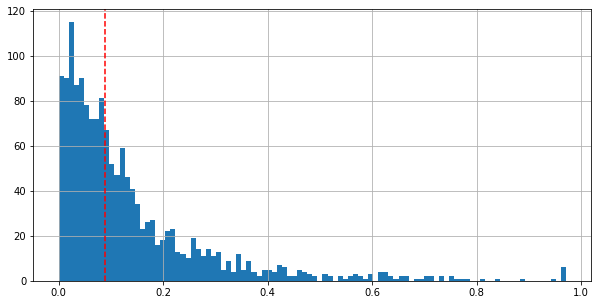

In [36]:
errors = df_eval.apply(lambda x: np.abs(x['pred'] - x['sale_price']) / (x['sale_price'] + 1e-6), axis=1)
errors[errors < 1].hist(bins=100, figsize=(10, 5));
plt.axvline(x=np.median(errors), color='red', linestyle='--');

In [37]:
df_eval_mdpe_by_pctl = df_eval.groupby('saleprice_percentile').apply(
    lambda x: median_percentage_error(x['sale_price'], x['pred']))
df_eval_mdpe_by_pctl = df_eval_mdpe_by_pctl.reset_index().rename({0: 'median_percentage_error'}, axis=1)
df_eval_mdpe_by_pctl['count'] = df_eval.groupby('saleprice_percentile').size().values

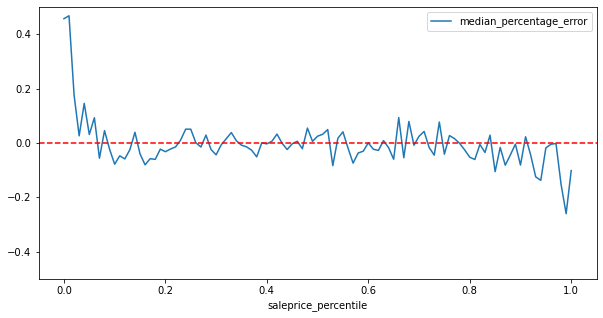

In [38]:
df_eval_mdpe_by_pctl.plot(x='saleprice_percentile', y='median_percentage_error', ylim=[-.5, .5], figsize=(10, 5));
plt.axhline(y=0, color='red', linestyle='--');

## Deep Learning

In [39]:
import copy

import numpy as np
import pandas as pd
from keras import backend as K
from keras import regularizers
from keras.layers import Activation, Concatenate, Dense, Embedding, Flatten, Input
from keras.models import Model
from keras.optimizers import Nadam
try:
    import tensorflow as tf
    tf.random.set_seed(0)
except Exception:
    pass

np.random.seed(0)

In [40]:
def make_features(df, feature_dict=None):
    """Make features."""
    df = df.copy()
    feature_dict = copy.deepcopy(feature_dict)

    feature_dict['nulls'] = []

    for level in [.01, .1]:
        name = 'lat_lon_' + str(level)
        mask = df['latitude'].isnull() | df['longitude'].isnull()
        df[name] = df.apply(lambda x: '{}_{}'.format(
            np.round(x['latitude'] / float(level)),
            np.round(x['longitude'] / float(level))
        ), axis=1)
        df.loc[mask, name] = np.nan

        feature_dict['cats'].append(name)
    feature_dict['nums'].remove('latitude')
    feature_dict['nums'].remove('longitude')

    return df if feature_dict is None else (df, feature_dict)

In [41]:
def get_model_data(df, feature_dict, data_info=None):
    """Get processed model data."""
    X = {}

    for key in feature_dict['nulls']:
        X[key] = np.array(df[[key]]).astype(np.float32)

    for key in feature_dict['nums'] + feature_dict['num_logs']:
        X[key] = np.array(df[[key]]).astype(np.float32)

    for key in feature_dict['cats']:
        X[key] = np.array(df[[key]]).astype(np.int32)

    return X


def get_model(X_train_dict, feature_dict):
    K.clear_session()

    inputs_num = []
    inputs_cat = []
    x_emb = []

    for key in X_train_dict:
        if key in feature_dict['nulls']:
            inputs_num.append(Input(shape=(1,), name=key))

        if key in feature_dict['nums']:
            inputs_num.append(Input(shape=(1,), name=key))

        if key in feature_dict['num_logs']:
            inputs_num.append(Input(shape=(1,), name=key))

        if key in feature_dict['cats']:
            emb = Input(shape=(1,), name=key)
            inputs_cat.append(emb)
            emb = Embedding(
                X_train_dict[key].max() + 2, 5,
                embeddings_regularizer=regularizers.l2(1e-6)
            )(emb)
            x_emb.append(Flatten()(emb))

    x = Concatenate()(inputs_num + x_emb)

    for size in [128, 32]:
        x = Dense(size)(x)
        x = Activation('relu')(x)

    outputs = Dense(1, activation='sigmoid')(x)

    inputs = inputs_num + inputs_cat
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Nadam(0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=None)

    return model

In [42]:
class FeatureEncoder:
    """Feature encoder."""
    def __init__(self, feature_dict, fill_value='-9999'):
        self.feature_dict_ = feature_dict
        self.fill_value_ = fill_value
        self.num_feature_medians_ = {}
        self.cat_feature_encoders_ = {}

    def fit(self, X):
        X = X.copy()

        for f in self.feature_dict_['nums'] + self.feature_dict_['num_logs']:
            if X[f].isnull().sum() > 0:
                X[f + '_isnull'] = 0
                X.loc[X[f].isnull(), f + '_isnull'] = 1
                self.feature_dict_['nulls'].append(f + '_isnull')

            if f in self.feature_dict_['num_logs']:
                X[f] = np.log1p(X[f])

            self.num_feature_medians_[f] = X[f].median()

            X[f] = X[f].fillna(self.num_feature_medians_[f])
            X[f] = X[f] - self.num_feature_medians_[f]

        for f in self.feature_dict_['cats']:
            X[f] = X[f].fillna(self.fill_value_)
            X[f] = X[f].astype(str)

            vals = list(set(X[f].values)) + [self.fill_value_]
            self.cat_feature_encoders_[f] = LabelEncoder().fit(vals)

            X[f] = self.cat_feature_encoders_[f].transform(X[f])

        return self

    def transform(self, X):
        X = X.copy()

        for f in self.feature_dict_['nulls']:
            f = feat[:-7]
            X[f + '_isnull'] = 0
            X.loc[X[f].isnull(), f + '_isnull'] = 1
    
        for f in self.feature_dict_['nums'] + self.feature_dict_['num_logs']:
            if f in self.feature_dict_['num_logs']:
                X[f] = np.log1p(X[f])

            X[f] = X[f].fillna(self.num_feature_medians_[f])
            X[f] = X[f] - self.num_feature_medians_[f]

        for f in self.feature_dict_['cats']:
            X[f] = X[f].fillna('-9999')
            X[f] = X[f].astype(str)

            idx = set(self.cat_feature_encoders_[f].classes_)
            X.loc[~X[f].isin(idx), f] = '-9999'

            X[f] = self.cat_feature_encoders_[f].transform(X[f])

        return X

    def fit_transform(self, X):
        return self.fit(X).transform(X)
    

class ResponseTransformer:
    """Response transformer."""
    def __init__(self):
        self.median = None

    def fit(self, y):
        y_trans = np.log1p(y)
        self.median = np.median(y_trans)
        return self

    def transform(self, y):
        y_median = np.median(self.median)
        y = np.log1p(y) - y_median
        return y

    def fit_transform(self, y):
        return self.fit(y).transform(y)

    def inverse_transform(self, y):
        y_median = np.median(self.median)
        y = np.expm1(y + y_median)
        return y

In [43]:
feature_encoder = FeatureEncoder(feature_dict)
response_transformer = ResponseTransformer()


def get_train_data(df_train):
    """Get training data."""
    df_train = df_train.copy()

    df_train, feature_dict_nn = make_features(df_train, feature_dict)

    X_train = df_train[feature_dict_nn['nums'] + feature_dict_nn['num_logs'] + feature_dict_nn['cats']]
    y_train = df_train[response_col]

    feature_encoder.feature_dict_ = feature_dict_nn

    X_train = get_model_data(feature_encoder.fit_transform(X_train), feature_dict_nn)
    y_train = response_transformer.fit_transform(y_train)

    return X_train, y_train, feature_dict_nn


def get_test_data(df_test):
    "Get test data."
    df_test = df_test.copy()

    df_test, feature_dict_nn = make_features(df_test, feature_dict)

    X_test = df_test[feature_dict_nn['nums'] + feature_dict_nn['num_logs'] + feature_dict_nn['cats']]
    y_test = df_test[response_col]

    X_test = get_model_data(feature_encoder.transform(X_test), feature_dict_nn)
    
    return X_test, y_test

In [44]:
def get_model_data(df, feature_dict, data_info=None):
    """Get processed model data."""
    X = {}

    for key in feature_dict['nulls']:
        X[key] = np.array(df[[key]]).astype(np.float32)

    for key in feature_dict['nums'] + feature_dict['num_logs']:
        X[key] = np.array(df[[key]]).astype(np.float32)

    for key in feature_dict['cats']:
        X[key] = np.array(df[[key]]).astype(np.int32)

    return X


def get_model(X_train_dict, feature_dict):
    """Get Keras model."""
    K.clear_session()

    inputs_num = []
    inputs_cat = []
    x_emb = []

    for key in X_train_dict:
        if key in feature_dict['nulls']:
            inputs_num.append(Input(shape=(1,), name=key))

        if key in feature_dict['nums']:
            inputs_num.append(Input(shape=(1,), name=key))

        if key in feature_dict['num_logs']:
            inputs_num.append(Input(shape=(1,), name=key))

        if key in feature_dict['cats']:
            emb = Input(shape=(1,), name=key)
            inputs_cat.append(emb)
            emb = Embedding(
                X_train_dict[key].max() + 2, 10,
                embeddings_regularizer=regularizers.l2(1e-6)
            )(emb)
            x_emb.append(Flatten()(emb))

    x = Concatenate()(inputs_num + x_emb)

    for size in [128, 32]:
        x = Dense(size)(x)
        x = Activation('relu')(x)

    outputs = Dense(1, activation='linear')(x)

    inputs = inputs_num + inputs_cat
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Nadam(0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=None)

    return model

In [45]:
X_train, y_train, feature_dict_nn = get_train_data(df_train)
reg_nn = get_model(X_train, feature_dict_nn)
reg_nn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sale_nbr (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
zoning (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
present_use (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
year_built (InputLayer)         [(None, 1)]          0                                            
______________________________________________________________________________________________

In [46]:
%time reg_nn.fit(X_train, y_train, batch_size=512, epochs=20, verbose=0);

CPU times: user 1min 2s, sys: 4.69 s, total: 1min 7s
Wall time: 25.6 s


In [47]:
X_test, y_test = get_test_data(df_test)
y_pred_nn = reg_nn.predict(X_test)
y_pred_nn = response_transformer.inverse_transform(y_pred_nn.squeeze())

In [48]:
pd.DataFrame([evaluate_preds(y_test, y_pred_nn)], index=['Neural Net'])

,R2,MAE,MdAE,MPE,MdPE,MAPE,MdAPE
Neural Net,0.885928,109717.793413,50899.90625,0.033581,-0.000154,0.130257,0.074032
